In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn 

In [2]:
bus = pd.read_csv('bus.csv.bz2')
ins = pd.read_csv('ins.csv.bz2')
ins2vio = pd.read_csv('ins2vio.csv.bz2')
vio = pd.read_csv('vio.csv.bz2')

## Data Analysis 

In [3]:
bus = bus.rename(columns ={'business id column':'bid'})

In [4]:
is_bid_unique = len(bus['bid'].unique()) == len(bus['bid'])

In [5]:
missing_zip_address_count = bus[bus['postal_code']== '-9999']['address'].value_counts()


In [6]:
is_ins_iid_a_primary_key = len(ins['iid'].unique()) == len(ins['iid'])

In [7]:
ins['bid'] = ins['iid'].str.split('_').str[0].apply(int)
ins['bid'] 

0        100010
1        100010
2        100017
3        100017
4        100017
          ...  
26658       999
26659       999
26660       999
26661        99
26662        99
Name: bid, Length: 26663, dtype: int64

In [8]:
ins['timestamp'] = pd.to_datetime(ins['date'])

In [9]:
earliest_date = min(ins['timestamp'])
latest_date = max(ins['timestamp'])

print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)

Earliest Date: 2016-10-04 00:00:00
Latest Date: 2019-11-28 00:00:00


In [10]:
ins['year'] = ins['timestamp'].dt.year

In [11]:
valid_zips = pd.read_json('sf_zipcodes.json',  dtype= object)['zip_codes']
valid_zips.head()

0    94102
1    94103
2    94104
3    94105
4    94107
Name: zip_codes, dtype: object

In [12]:
invalid_zip_bus = bus[~bus['postal_code'].isin(valid_zips)]

In [13]:
bus['postal5'] = bus['postal_code'].str[0:5]
bus['postal5'].loc[bus['postal5'].isin(valid_zips) == False] = None


# Checking the corrected postal5 column
bus.loc[invalid_zip_bus.index, ['bid', 'name', 'postal_code', 'postal5']]

/Users/jordan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,bid,name,postal_code,postal5
22,100126,Lamas Peruvian Food Truck,-9999,None
68,100417,"COMPASS ONE, LLC",94105-1420,94105
96,100660,TEAPENTER,94122-1909,94122
109,100781,LE CAFE DU SOLEIL,94117-3504,94117
144,101084,Deli North 200,94518,None
...,...,...,...,...
6173,99369,HOTEL BIRON,94102-5917,94102
6174,99376,Mashallah Halal Food truck Ind,-9999,None
6199,99536,FAITH SANDWICH #2,94105-2907,94105
6204,99681,Twister,95112,None


In [14]:
ins_pivot = ins.pivot_table(index ='type', columns = 'year', aggfunc= 'size', fill_value = 0)
ins_pivot['Total'] = ins_pivot.sum(axis=1)
ins_pivot_sorted  = ins_pivot.sort_values(by = 'Total', ascending=False)
ins_pivot_sorted

year,2016,2017,2018,2019,Total
type,,,,,
Routine - Unscheduled,966,4057,4373,4681,14077
Reinspection/Followup,445,1767,1935,2292,6439
New Ownership,99,506,528,459,1592
Complaint,91,418,512,437,1458
New Construction,102,485,218,189,994
Non-inspection site visit,51,276,253,231,811
New Ownership - Followup,0,45,219,235,499
Structural Inspection,1,153,50,190,394
Complaint Reinspection/Followup,19,68,70,70,227


In [15]:
ins_missing_score_pivot = ins[['type','score']]
ins_missing_score_pivot['missing_value'] = ins_missing_score_pivot['score'].isin([-1])
ins_missing_score_pivot = ins_missing_score_pivot.pivot_table(index='type', columns = 'missing_value', aggfunc= 'size', fill_value = 0)
ins_missing_score_pivot['Total'] = ins_missing_score_pivot.sum(axis=1)
ins_pivot_sorted  = ins_missing_score_pivot .sort_values(by = 'Total', ascending=False)
ins_pivot_sorted 

/Users/jordan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


missing_value,False,True,Total
type,,,
Routine - Unscheduled,14031,46,14077
Reinspection/Followup,0,6439,6439
New Ownership,0,1592,1592
Complaint,0,1458,1458
New Construction,0,994,994
Non-inspection site visit,0,811,811
New Ownership - Followup,0,499,499
Structural Inspection,0,394,394
Complaint Reinspection/Followup,0,227,227


In [16]:
ins_named = pd.merge(ins,bus, how= 'left', on = 'bid').drop(['city', 'state', 'postal_code', 'latitude', 'longitude', 'phone_number', 'postal5'], axis=1)
ins_named.head()

,iid,date,score,type,bid,timestamp,year,name,address
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction,100010,2019-03-29,2019,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03,2019,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership,100017,2019-04-17,2019,AMICI'S EAST COAST PIZZERIA,475 06th St
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16,2019,AMICI'S EAST COAST PIZZERIA,475 06th St
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup,100017,2019-08-26,2019,AMICI'S EAST COAST PIZZERIA,475 06th St


In [17]:
twenty_lowest_scoring = ins_named[['bid','name','score']]
twenty_lowest_scoring = twenty_lowest_scoring.where(twenty_lowest_scoring['score'] > -1).groupby(['bid', 'name'], as_index = False).median()
twenty_lowest_scoring = twenty_lowest_scoring.sort_values(by ='score', ascending=True)[:20]
twenty_lowest_scoring['bid'] = twenty_lowest_scoring['bid'].astype(int)
twenty_lowest_scoring = twenty_lowest_scoring.rename(columns = {'score' : 'median score'})
twenty_lowest_scoring 


,bid,name,median score
3876,84590,Chaat Corner,54.0
4564,90622,Taqueria Lolita,57.0
4990,94351,VBowls LLC,58.0
2719,69282,New Jumbo Seafood Restaurant,60.5
222,1154,SUNFLOWER RESTAURANT,63.5
1991,39776,Duc Loi Supermarket,64.0
2734,69397,Minna SF Group LLC,64.0
4870,93150,Chez Beesen,64.0
4911,93502,Smoky Man,64.0
3291,78328,Golden Wok,64.0


In [18]:
merge_vid = pd.merge(vio, ins2vio)
merge_iid = pd.merge(ins, merge_vid)
low_score_violations = merge_iid.where(merge_iid['score'] > -1)
low_score_violations = low_score_violations.where(low_score_violations['score'] < 65)
low_score_violations = low_score_violations.dropna()['description']
low_score_violations = low_score_violations.value_counts()
low_score_violations

Unclean or unsanitary food contact surfaces                                  43
High risk food holding temperature                                           42
Unclean or degraded floors walls or ceilings                                 40
Unapproved or unmaintained equipment or utensils                             39
High risk vermin infestation                                                 37
Foods not protected from contamination                                       37
Inadequate food safety knowledge or lack of certified food safety manager    35
Inadequate and inaccessible handwashing facilities                           35
Improper thawing methods                                                     30
Unclean hands or improper use of gloves                                      27
Improper cooling methods                                                     25
Unclean nonfood contact surfaces                                             21
Inadequately cleaned or sanitized food c

In [19]:
twenty_reason = pd.merge(merge_iid[['bid','description']], twenty_lowest_scoring, how = 'inner', on = 'bid')
twenty_reason = twenty_reason.groupby(['name','bid','median score']).head(20).sort_values(by ='median score', ascending=True)
reasons = twenty_reason.groupby(['name','bid','median score'])['description'].apply(list)
twenty_reason
reasons[0]

['Improper food storage',
 'Improper thawing methods',
 'Wiping cloths not clean or properly stored or inadequate sanitizer',
 'Unclean or unsanitary food contact surfaces',
 'Unclean or degraded floors walls or ceilings',
 'Unapproved or unmaintained equipment or utensils',
 'Permit license or inspection report not posted',
 'Noncompliance with Gulf Coast oyster regulation',
 'Moderate risk vermin infestation',
 'Inadequate food safety knowledge or lack of certified food safety manager',
 'Inadequate and inaccessible handwashing facilities',
 'Improper storage use or identification of toxic substances',
 'High risk food holding temperature',
 'Foods not protected from contamination',
 'Employee eating or smoking',
 'Unclean or unsanitary food contact surfaces',
 'Unclean or degraded floors walls or ceilings',
 'Inadequate and inaccessible handwashing facilities',
 'Improper thawing methods']

## Data Visualization

In [20]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')

In [21]:
ins = pickle.load(open('ins.p', 'rb'))
vio = pickle.load(open('vio.p', 'rb'))
ins2vio = pickle.load(open('ins2vio.p', 'rb'))
bus = pickle.load(open('bus.p', 'rb'))

Text(0.5, 1.0, 'Score Count of Restaurants')

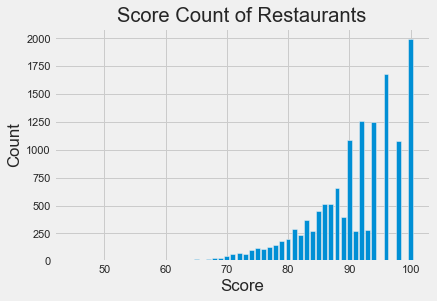

In [36]:
ins = ins[(ins.loc[:,'score'] > 0) & (ins['Missing Score'] == 'False')].dropna()
count = ins['score'].value_counts()
plt.bar(count.index, count)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Score Count of Restaurants')

In [23]:
ins_named = pd.merge(ins, bus[['bid', 'name', 'address']], how= 'left', on='bid')

ins_named.head()

,iid,date,score,type,bid,timestamp,year,Missing Score,name,address
0,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03,2019,False,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B
1,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16,2019,False,AMICI'S EAST COAST PIZZERIA,475 06th St
2,100041_20190520,05/20/2019 12:00:00 AM,83,Routine - Unscheduled,100041,2019-05-20,2019,False,UNCLE LEE CAFE,3608 BALBOA ST
3,100055_20190425,04/25/2019 12:00:00 AM,98,Routine - Unscheduled,100055,2019-04-25,2019,False,Twirl and Dip,335 Martin Luther King Jr. Dr
4,100055_20190912,09/12/2019 12:00:00 AM,82,Routine - Unscheduled,100055,2019-09-12,2019,False,Twirl and Dip,335 Martin Luther King Jr. Dr


In [24]:
worst_restaurant = ins_named[ins_named['score'] == min(ins_named['score'])]
worst_restaurant

,iid,date,score,type,bid,timestamp,year,Missing Score,name,address
10898,86718_20180522,05/22/2018 12:00:00 AM,45,Routine - Unscheduled,86718,2018-05-22,2018,False,Lollipot,890 Taraval St


In [25]:
k = [ins_named["name"].value_counts() >= 3]
valid_index = np.nonzero(k)[1]
valid_restaurant = [k[0].index.array[i] for i in valid_index] 
valid_restaurant = ins_named[ins_named["name"].isin(valid_restaurant)]
max_score = valid_restaurant.groupby("bid")['score'].max()
min_score = valid_restaurant.groupby("bid")['score'].min()
difference =  max_score - min_score
swings = difference[difference !=0]
max_bid = swings[swings == max(swings)].index[0]
max_swing = ins_named[ins_named["bid"] == max_bid]['name'].array[0]
max_swing

'Lollipot'

In [26]:
inspections_by_id_and_year = ins_named.groupby(
    ["bid", "year"]).agg("count")[["iid"]].rename(columns = {"iid": "count"})
inspections_by_id_and_year

count
bid    year       
19     2017      1
       2018      1
24     2016      1
       2017      1
       2019      1
...            ...
101853 2019      1
102067 2019      1
102257 2019      1
102336 2019      1
102398 2019      1

[12293 rows x 1 columns]

In [27]:
inspections_by_id_and_year['count'].value_counts()

1    10580
2     1688
3       25
Name: count, dtype: int64

In [28]:
# ins2018 = ins[ins['year'] == 2018]
ins_year_id = inspections_by_id_and_year.reset_index()
# Create the dataframe here
valid_count = ins_year_id[ins_year_id["count"] == 2]
valid_year = pd.merge(valid_count[valid_count["year"] == 2018], 
                      ins, how = 'right', on = ["bid", "year"]).dropna()
scores_pairs_by_business = valid_year[["bid","score"]].groupby(
    "bid").agg(list).rename(columns = {"score": "score_pair"})
scores_pairs_by_business

# scores_pairs_by_business = inspections_by_id_and_year[inspections_by_id_and_year["count"] == 2]
# scores_pairs_by_business


,score_pair
bid,
48,"[94, 87]"
66,"[98, 98]"
146,"[81, 90]"
184,"[90, 96]"
273,"[83, 84]"
...,...
95621,"[100, 100]"
95628,"[75, 75]"
95674,"[100, 96]"


Text(0.5, 1.0, 'First Inspection Score vs. Second Inspection Score')

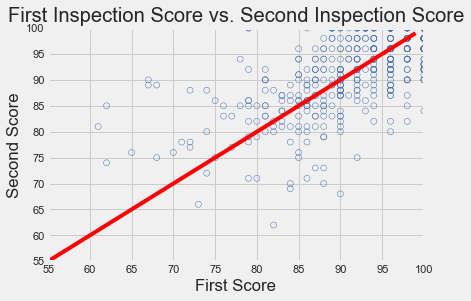

In [29]:
# plt.scatter()
first_point = [i[0] for i in scores_pairs_by_business["score_pair"].array]
second_point = [i[1] for i in scores_pairs_by_business["score_pair"].array]
plt.scatter(first_point, second_point, facecolors='none', edgecolors= 'b'  )
plt.plot(range(55,100, 1),range(55,100, 1), color = 'red' )
plt.axis([55, 100, 55, 100])
plt.xlabel("First Score")
plt.ylabel("Second Score")
plt.title("First Inspection Score vs. Second Inspection Score")

Text(0.5, 1.0, 'Distribution of Score Differences')

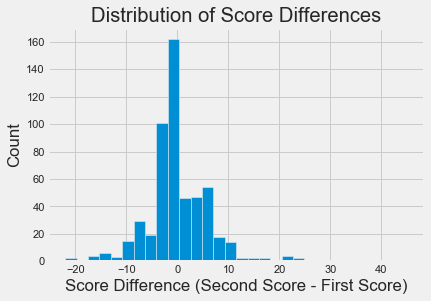

In [30]:
difference = [second_point[i] - first_point[i] for i in np.arange(len(second_point))]
plt.hist(difference, 30)
plt.xlabel("Score Difference (Second Score - First Score)")
plt.ylabel("Count")
plt.title("Distribution of Score Differences")

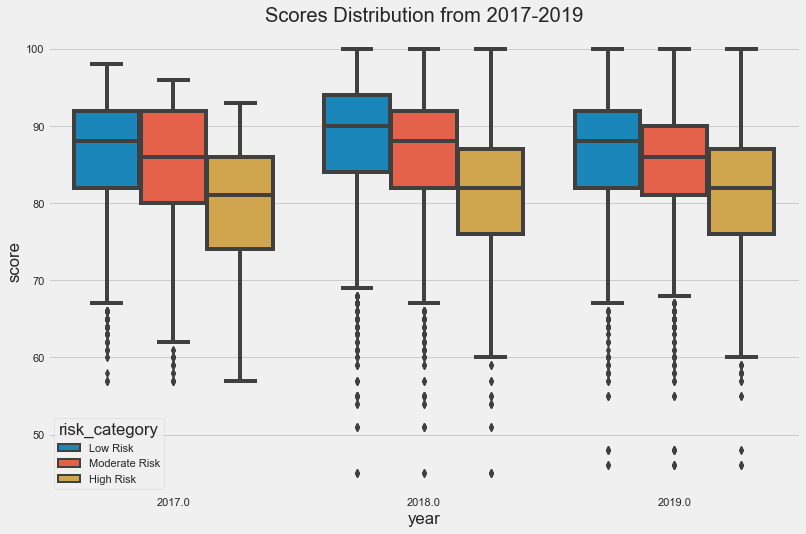

In [38]:
# Do not modify this line
# sns.set()

vio_with_risks = pd.merge(ins2vio, vio, how = "left", on = "vid")
# risks_year = pd.merge(vio_with_risks[vio_with_risks["iid", "risk_category"]], ins[ins["iid","score","year"]], how = "left", on="iid")
# vio_with_risks[vio_with_risks["iid", "risk_category"]]
# risks_year = pd.merge(vio_with_risks[vio_with_risks["iid", "risk_category"]], ins[ins["iid","score","year"]], how = "left", on="iid")
# vio_with_risks["iid", "risk_category"]
risks_year = pd.merge(vio_with_risks[["iid", "risk_category"]],
                      ins[["iid","score","year"]], 
                      how = "left", 
                      on="iid").dropna()
risks_year = risks_year[risks_year["year"] > 2016]
plt.figure(figsize =[12,8])
plt.title("Scores Distribution from 2017-2019")
sns.boxplot(x = risks_year["year"], y = risks_year["score"], 
            hue = risks_year["risk_category"], 
            hue_order = ["Low Risk", "Moderate Risk", "High Risk"])

In [39]:
valid_score_lola = pd.merge(ins, bus, how = "left", on = "bid").dropna().loc[:,[
    "latitude", "longitude", "score", "year"]] 
valid_score_lola = valid_score_lola[(valid_score_lola.loc[:, "latitude"] >= 37.675 ) 
                                    & (valid_score_lola.loc[:, "latitude"] <= 37.825 ) ]
rated_geo_with_date = valid_score_lola[(valid_score_lola.loc[:, "longitude"] >= -122.52 ) 
                                       & (valid_score_lola.loc[:, "longitude"] <= -122.36 )]
rated_geo = rated_geo_with_date.loc[:,["latitude", "longitude", "score"]] 
rated_geo

,latitude,longitude,score
16,37.755282,-122.420493,74
17,37.755282,-122.420493,76
18,37.755282,-122.420493,72
36,37.752158,-122.420362,85
37,37.752158,-122.420362,90
...,...,...,...
14026,37.756997,-122.420534,77
14027,37.756997,-122.420534,80
14028,37.756997,-122.420534,80
14029,37.794293,-122.405967,82


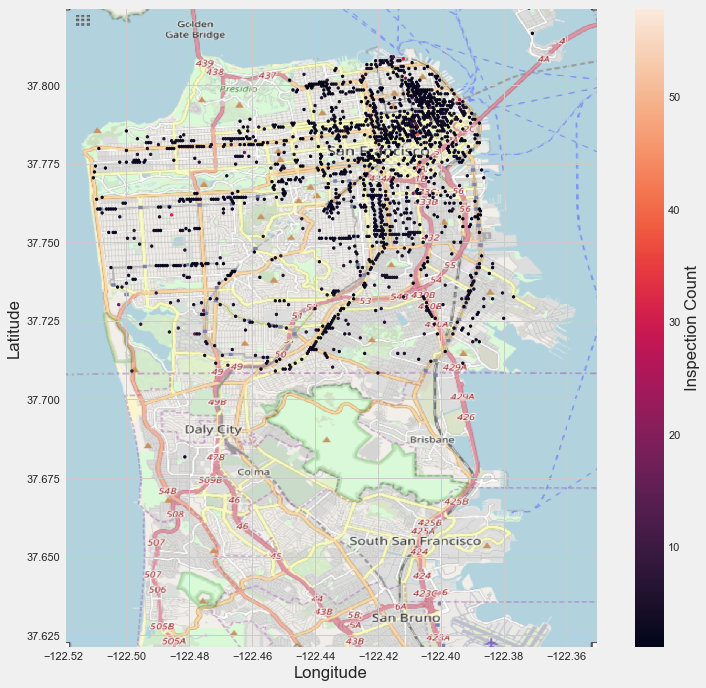

In [33]:
# DO NOT MODIFY THIS BLOCK
min_lon = rated_geo['longitude'].min()
max_lon = rated_geo['longitude'].max()
min_lat = rated_geo['latitude'].min()
max_lat = rated_geo['latitude'].max()
max_score = rated_geo['score'].max()
min_score = rated_geo['score'].min()
bound = ((min_lon, max_lon, min_lat, max_lat))
min_lon, max_lon, min_lat, max_lat
map_bound = ((-122.5200, -122.3500, 37.6209, 37.8249))
# DO NOT MODIFY THIS BLOCK

# Read in the base map and setting up subplot
# DO NOT MODIFY THESE LINES
basemap = plt.imread('sf.png')
fig, ax = plt.subplots(figsize = (11,11))
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])
# DO NOT MODIFY THESE LINES


# Create the hexbin plot
rated = rated_geo.set_index(["latitude", "longitude"]).index.value_counts()
count= rated.array
latitudes = [rated.index[i][0] for i in np.arange(len(rated.index))]
longitudes = [rated.index[i][1] for i in np.arange(len(rated.index))]
hex_bin = plt.hexbin(longitudes,latitudes, C=count, gridsize=200 )
fig.colorbar(hex_bin).set_label("Inspection Count")
plt.xlabel("Longitude")
plt.ylabel("Latitude")


# Setting aspect ratio and plotting the hexbins on top of the base map layer
# DO NOT MODIFY THIS LINE
ax.imshow(basemap, zorder=0, extent = map_bound, aspect= 'equal');
# DO NOT MODIFY THIS LINE

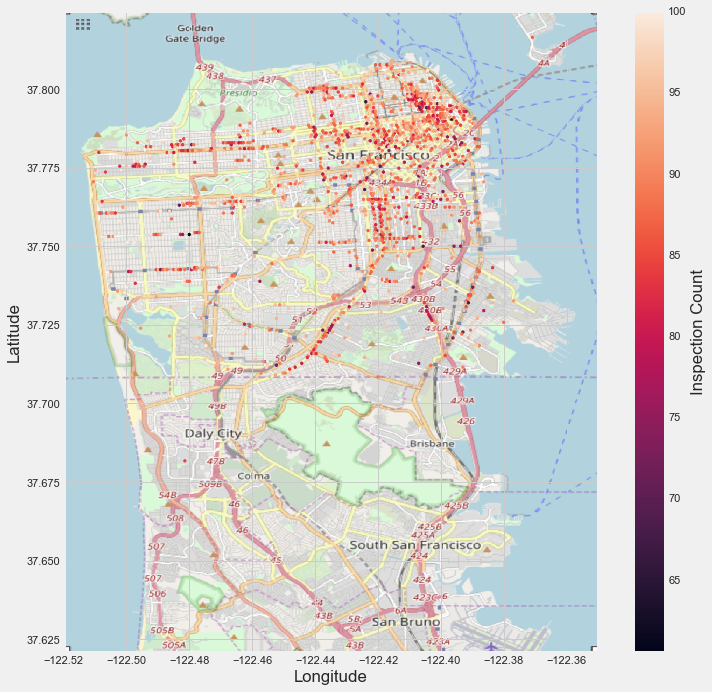

In [34]:
# Read in the base map and setting up subplot
# DO NOT MODIFY THESE LINES
basemap = plt.imread('sf.png')
fig, ax = plt.subplots(figsize = (11,11))
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])
# DO NOT MODIFY THESE LINES

# Create the hexbin plot
rated = rated_geo.groupby(["latitude", "longitude"]).agg(list)
score = [np.mean(i) for i in rated.loc[:,"score"]]
latitudes = [rated.index[i][0] for i in np.arange(len(rated.index))]
longitudes = [rated.index[i][1] for i in np.arange(len(rated.index))]
hex_bin = plt.hexbin(longitudes,latitudes, C=score, reduce_C_function = np.mean, gridsize=200 )
fig.colorbar(hex_bin).set_label("Inspection Count")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Setting aspect ratio and plotting the hexbins on top of the base map layer
# DO NOT MODIFY THIS LINE
ax.imshow(basemap, zorder=0, extent = map_bound, aspect= 'equal');
# DO NOT MODIFY THIS LINE

<Figure size 432x288 with 0 Axes>

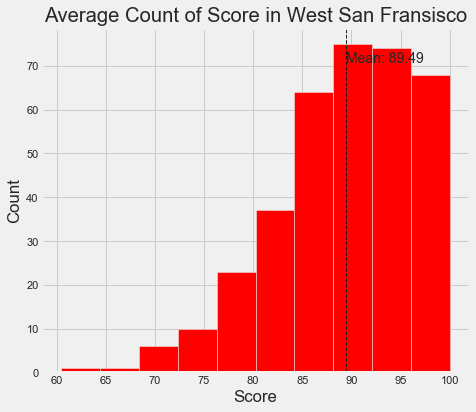

<Figure size 432x288 with 0 Axes>

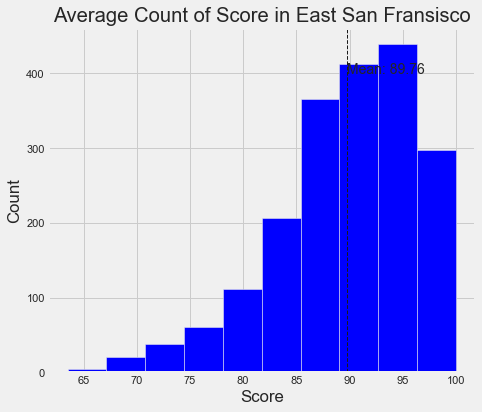

<Figure size 432x288 with 0 Axes>

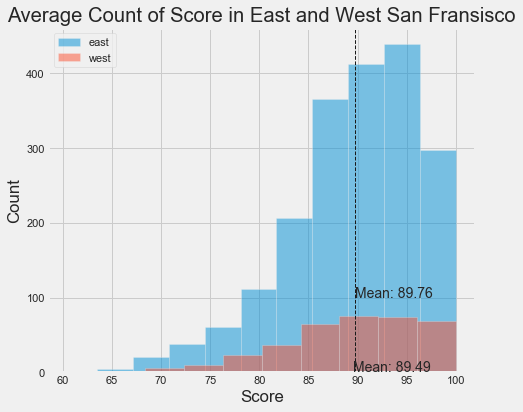

<Figure size 432x288 with 0 Axes>

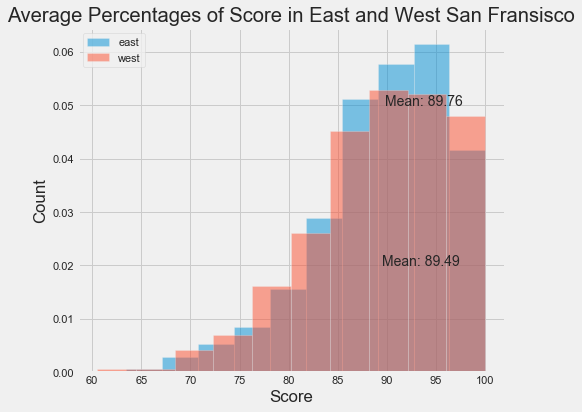

In [35]:
# YOUR DATA PROCESSING AND PLOTTING HERE
rated_geo
west_san_fransisco = rated_geo[(rated_geo.loc[:,"longitude"] <= -122.46)]
east_san_fransisco = rated_geo[(rated_geo.loc[:,"longitude"] > -122.46)]
east_scores = east_san_fransisco.groupby(["latitude", "longitude"]).agg(list)
west_scores = west_san_fransisco.groupby(["latitude", "longitude"]).agg(list)
west_averages = [np.mean(i) for i in west_scores.loc[:,"score"]]
east_averages = [np.mean(i) for i in east_scores.loc[:,"score"]]
# fig, axs = plt.subplots(2)


plt.figure()
plt.figure(figsize =[15,13])
plt.subplot(2,2,1)
plt.hist(west_averages, color = "red")
min_ylim, max_ylim = plt.ylim()
plt.axvline(np.mean(west_averages), color='k', linestyle='dashed', linewidth=1) 
plt.text(np.mean(west_averages),max_ylim*0.9,'Mean: {:.2f}'.format(np.mean(west_averages)))
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Average Count of Score in West San Fransisco")



plt.figure()
plt.figure(figsize =[15,13])
plt.subplot(2,2,2)
min_ylim, max_ylim = plt.ylim()
plt.hist(east_averages, color = "blue")
plt.axvline(np.mean(east_averages), color='k', linestyle='dashed', linewidth=1) 
plt.text(np.mean(east_averages),400,'Mean: {:.2f}'.format(np.mean(east_averages)))
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Average Count of Score in East San Fransisco")


plt.figure()
plt.figure(figsize =[15,13])
plt.subplot(2,2,3)
min_ylim, max_ylim = plt.ylim()
plt.hist(east_averages, alpha=0.5, label= "east")
plt.hist(west_averages, alpha=0.5, label= "west")
plt.axvline(np.mean(east_averages), color='k', linestyle='dashed', linewidth=1) 
plt.text(np.mean(east_averages),100,'Mean: {:.2f}'.format(np.mean(east_averages)))
plt.text(np.mean(west_averages),max_ylim*0.9,'Mean: {:.2f}'.format(np.mean(west_averages)))
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Average Count of Score in East and West San Fransisco")
plt.legend(loc ="upper left")



plt.figure()
plt.figure(figsize =[15,13])
plt.subplot(2,2,4)
plt.hist(east_averages, alpha=0.5, label= "east", density = True)
plt.hist(west_averages, alpha=0.5, label= "west", density = True)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(east_averages),0.05,'Mean: {:.2f}'.format(np.mean(east_averages)))
plt.text(np.mean(west_averages),0.02,'Mean: {:.2f}'.format(np.mean(west_averages)))
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Average Percentages of Score in East and West San Fransisco")
plt.legend(loc ="upper left")



# axs[0].hist(west_averages)
# axs[1].hist(east_averages)
# plt.hist(east_averages, alpha=0.5, label= "east", density = True)
# plt.hist(west_averages, alpha=0.5, label= "west", density = True)

# plt.legend(loc ="upper left")
plt.show()



# YOUR EXPLANATION HERE (in a comment)
#I graphed the avergae count of score in West and East San Fransico on the top two graphs. 
#However, I noticed that the scale of the count does not represent both graphs in an equal way and we can see that
#when we overlap the two data on the third graph, there is a huge difference in the numbers becuase there are more
#restaurants in the east than the west. However, when we take the percentage of the mean,
#we get a better depiction distribution of the avergae inspection scores. The last table shows us that the 
#avergae between the west and east are quite close. If we did not use the percentage, we would
#arrive at a different conclusion based on the third graph.